In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F


from sklearn.model_selection import train_test_split
import os
import math
import matplotlib.pyplot as plt
import time

import Modules.ResNet1 as rs1
import Modules.UNet as un
import Modules.NewUNet as nun
import Modules.CNN1418 as cnn1418
import Modules.CNN138 as cnn138
import Modules.CNN1525 as cnn1525
import Modules.ANN1418 as ann1418
import Modules.ANN138 as ann138
import Modules.ANN1525 as ann1525
import Modules.CNN14181 as cnn14181
import Modules.CNN1381 as cnn1381
import Modules.CNN15251 as cnn15251
import Modules.ANN14181 as ann14181
import Modules.ANN1381 as ann1381
import Modules.ANN15251 as ann15251

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)


In [3]:
def randomSeedInitial(seed=256, cudnnDeterministic=True, cudnnBenchmark=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 为了保证可复现性, defaul True False; False True 可能可以提升gpu运行效率
    torch.backends.cudnn.deterministic = cudnnDeterministic
    torch.backends.cudnn.benchmark = cudnnBenchmark

In [4]:
begin_time = time.time()

In [5]:
randomSeedInitial(256)

In [6]:
# 单污染源
# 8x13
# train = np.load('./13x8/all/allconc.npy', allow_pickle=True)
# 15x25
# train = np.load('./15x25/all/allconc.npy', allow_pickle=True)
# 18x14
# train = np.load('./high/all/allconc.npy', allow_pickle=True)
# 多污染源
# 8x13
train = np.load('./13x8d/all/allconc.npy', allow_pickle=True)
# 15x25
# train = np.load('./15x25d/all/allconc.npy', allow_pickle=True)
# 18x14
# train = np.load('./14x18d/all/allconc.npy', allow_pickle=True)

In [7]:
class MyDataset(Dataset):
    def __init__(self, x: np.numarray, y: np.numarray):
        """
        :param x: shape like (n_sample, t, n_well)
        :param y: shape like (n_sample, t, h, w)
        :param z: shape like (n, h, w)
        """
        super(MyDataset, self).__init__()
        self.x = torch.from_numpy(x).to(torch.float32)
        self.y = torch.from_numpy(y).to(torch.float32)

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, item):
        return self.x[item], self.y[item]

In [8]:
label = []
train_input = []

for k in range(len(train)):
    label.append(train[k][1])
    train_input.append(train[k][-1])
# label = (np.array(label)).reshape(100, 1, 18, 14)*100000
# train = (np.array(train_input)).reshape(100, 1, 18, 14)*100000
# label = (np.array(label)).reshape(100, 1, 18, 14)*1
# train = (np.array(train_input)).reshape(100,1,18,14)*1
label = (np.array(label)).reshape(len(label), 1, 8, 13)*1000
train = (np.array(train_input)).reshape(len(label),1,8,13)*1000
# label = (np.array(label)).reshape(len(label), 1, 15, 25)*1000
# train = (np.array(train_input)).reshape(len(train),1,15,25)*1000

# label = (np.array(label)).reshape(len(label), 15, 25)*100
# train = (np.array(train_input)).reshape(len(train),15,25)*100

X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=256)

In [8]:
# # # 归一化处理
# # X_train.shape
# train_max = X_train.max(axis=(0, 1))
# train_min = X_train.min(axis=(0, 1))
# X_train = (X_train - train_min) / (train_max - train_min)
# X_test = (X_test - train_min) / (train_max - train_min)
# y_train_max = y_train.max()
# y_train_min = y_train.min()
# y_train = (y_train - y_train_min) / (y_train_max - y_train_min)
# y_test = (y_test - y_train_min) / (y_train_max - y_train_min)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125, random_state=256)
train_data = MyDataset(X_train, y_train)
val_data = MyDataset(X_valid, y_valid)
test_data = MyDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_data, batch_size=7, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=5, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=test_data, batch_size=10, shuffle=False, drop_last=False)

In [10]:
# model = nun.UNet()
model = rs1.ResNet()
# model = cnn1525.Net()
if torch.cuda.is_available():
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 20], 0.1)
loss_func = nn.MSELoss()

In [11]:
os.makedirs('./output', exist_ok=True)
best = 10000000
for epoch in range(5000):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch, (batch_x, batch_y) in enumerate(train_loader):
        if torch.cuda.is_available():
            batch_x, batch_y = Variable(batch_x.cuda()), Variable(batch_y.cuda())
        out = model(batch_x)  
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        train_corret = abs(out - batch_y).sum()
        train_acc += train_corret.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%50==0:
        print(f'Epoch: {epoch}', 'Train Loss: %.6f, Acc: %.3f' % (train_loss / (math.ceil(len(train_data) / 7)),train_acc / (len(train_data))))
    
    model.eval()
    eval_loss = 0
    eval_acc = 0
    for batch_x, batch_y in val_loader:
        if torch.cuda.is_available():
            batch_x, batch_y = Variable(batch_x.cuda()), Variable(batch_y.cuda())

        out = model(batch_x)
        loss = loss_func(out, batch_y)
        eval_loss += loss.item()
        num_correct = abs(out - batch_y).sum()
        eval_acc += num_correct.item()
    if epoch%50==0:
        print('Val Loss: %.6f, Acc: %.3f' % (eval_loss / (math.ceil(len(val_data) / 7)),
                                             eval_acc / (len(val_data))))
    if (eval_acc / (len(val_data))) < best:
        best = eval_acc / (len(val_data))
        torch.save(model.state_dict(), 'output/15x25/EDCNNid1.pth')
#         torch.save(model.state_dict(), 'output/13x8/ANNid.pth')
#         torch.save(model.state_dict(), 'output/14x18/ANNid1.pth')

Epoch: 0 Train Loss: 215.366052, Acc: 616.399
Val Loss: 204.266167, Acc: 476.486
Epoch: 50 Train Loss: 113.660371, Acc: 224.609
Val Loss: 154.342537, Acc: 320.436
Epoch: 100 Train Loss: 114.521358, Acc: 229.497
Val Loss: 140.219658, Acc: 310.501
Epoch: 150 Train Loss: 113.754206, Acc: 226.743
Val Loss: 171.141090, Acc: 336.134
Epoch: 200 Train Loss: 112.991610, Acc: 214.486
Val Loss: 137.011177, Acc: 292.345
Epoch: 250 Train Loss: 113.443978, Acc: 221.987
Val Loss: 148.369019, Acc: 310.381
Epoch: 300 Train Loss: 113.066299, Acc: 216.406
Val Loss: 153.380974, Acc: 308.527
Epoch: 350 Train Loss: 113.012515, Acc: 215.163
Val Loss: 154.811287, Acc: 312.990
Epoch: 400 Train Loss: 118.179095, Acc: 245.808
Val Loss: 147.046288, Acc: 298.366
Epoch: 450 Train Loss: 112.978407, Acc: 213.993
Val Loss: 143.867943, Acc: 281.770
Epoch: 500 Train Loss: 113.239280, Acc: 219.862
Val Loss: 143.549095, Acc: 286.898
Epoch: 550 Train Loss: 112.988695, Acc: 214.272
Val Loss: 143.935822, Acc: 284.820
Epoch: 

In [13]:
# model = nun.UNet()
model = rs1.ResNet()
# model = cnn1525.Net()
if torch.cuda.is_available():
    model.cuda()
# model.load_state_dict(torch.load('output/15x25/EDCNNid1.pth'))
model.load_state_dict(torch.load('output/13x8/rsid.pth'))
# model.load_state_dict(torch.load('output/14x18/ANNid1.pth'))
model.eval()
plot_data = []
if torch.cuda.is_available():
    model.cuda()
eval_loss = 0
eval_acc = 0
for batch_x, batch_y in test_loader:
    if torch.cuda.is_available():
        batch_x, batch_y = Variable(batch_x.cuda()), Variable(batch_y.cuda())
            
    out = model(batch_x)

    plot_data = out
    loss = loss_func(out, batch_y)
    eval_loss += loss.item()
    num_correct = abs(out - batch_y).sum()
    eval_acc += num_correct.item()
# print('Val Loss: %.6f, Acc: %.3f' % (eval_loss / (math.ceil(len(val_data) / 7)),
#                                      eval_acc / (len(val_data))))
plot_data1 = batch_y.cpu()
plot_data = plot_data.cpu()
# print(plot_data.shape)
# print(plot_data1.shape)

### 依次为MAE、MSE、RMSE、MAPE、NE、ME、R2

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import r2_score

plot_data = plot_data.detach().numpy()
plot_data1 = plot_data1.detach().numpy()

# plot_data = plot_data.reshape(len(plot_data),15,25)
# plot_data1 = plot_data1.reshape(len(plot_data),15,25)
plot_data = plot_data.reshape(len(plot_data),8,13)
plot_data1 = plot_data1.reshape(len(plot_data1),8,13)
# plot_data = plot_data.reshape(len(plot_data),18,14)
# plot_data1 = plot_data1.reshape(len(plot_data),18,14)
c = abs(plot_data1-plot_data)
# print(plot_data.shape)
end_time = time.time()

run_time = round(end_time-begin_time)
# 计算时分秒
hour = run_time//3600
minute = (run_time-3600*hour)//60
second = run_time-3600*hour-60*minute
# 输出
# print (f'该程序运行时间：{hour}小时{minute}分钟{second}秒')

# with open('评价结果存放EDCNN1525d.txt','a') as file_handle:
#     for j in range(len(plot_data1)):
#     #     print('Picture' + str(j))
#     #     print('True1: '+ str(np.max(plot_data1[j])))
#     #     print('Estimate1: '+ str(np.max(plot_data[j])))
#     #     print('True2: '+ str(np.sort(plot_data1[j].reshape(1,-1))[0][-2]))
#     #     print('Estimate2: ' + str(np.sort(plot_data[j].reshape(1,-1))[0][-2]))
#     #     print('MAE:  '+str(mean_absolute_error(plot_data1[j],plot_data[j])))#Y_real为实际值，Y_pre为预测值
#     #     print('RMSE:  '+str(np.sqrt(mean_squared_error(plot_data1[j],plot_data[j]))))
#         a = np.cumsum(plot_data[j])
#         b = np.cumsum(plot_data1[j])
#     #     print('NE:  '+str(abs(a[-1]-b[-1])/b[-1]))
#         #     print('ME:  '+str(abs(a[-1]-b[-1])/(13*8)))
#         #     print('R2:  '+str(r2_score(plot_data1[j],plot_data[j])))
#         #     print('MSE:  '+str(mean_squared_error(plot_data1[j],plot_data[j])))

#         print()
# #         with open('评价结果存放UNet1525.txt','a') as file_handle:   # .txt可以不自己新建,代码会自动新建
#         file_handle.write('Picture' + str(j) + '\n')
#         file_handle.write('True1: '+ str(np.max(plot_data1[j])) + '\n')
#         file_handle.write('Estimate1: '+ str(np.max(plot_data[j])) + '\n')
#         file_handle.write('True2: '+ str(np.sort(plot_data1[j].reshape(1,-1))[0][-2]) + '\n')
#         file_handle.write('Estimate2: ' + str(np.sort(plot_data[j].reshape(1,-1))[0][-2]) + '\n')
#         file_handle.write('MAE:  '+str(mean_absolute_error(plot_data1[j],plot_data[j])) + '\n')
#         file_handle.write('RMSE:  '+str(np.sqrt(mean_squared_error(plot_data1[j],plot_data[j]))) + '\n')
#         file_handle.write('NE:  '+str(abs(a[-1]-b[-1])/b[-1]) + '\n')
#         file_handle.write('\n')
#     file_handle.write(f'该程序运行时间：{hour}小时{minute}分钟{second}秒')

10


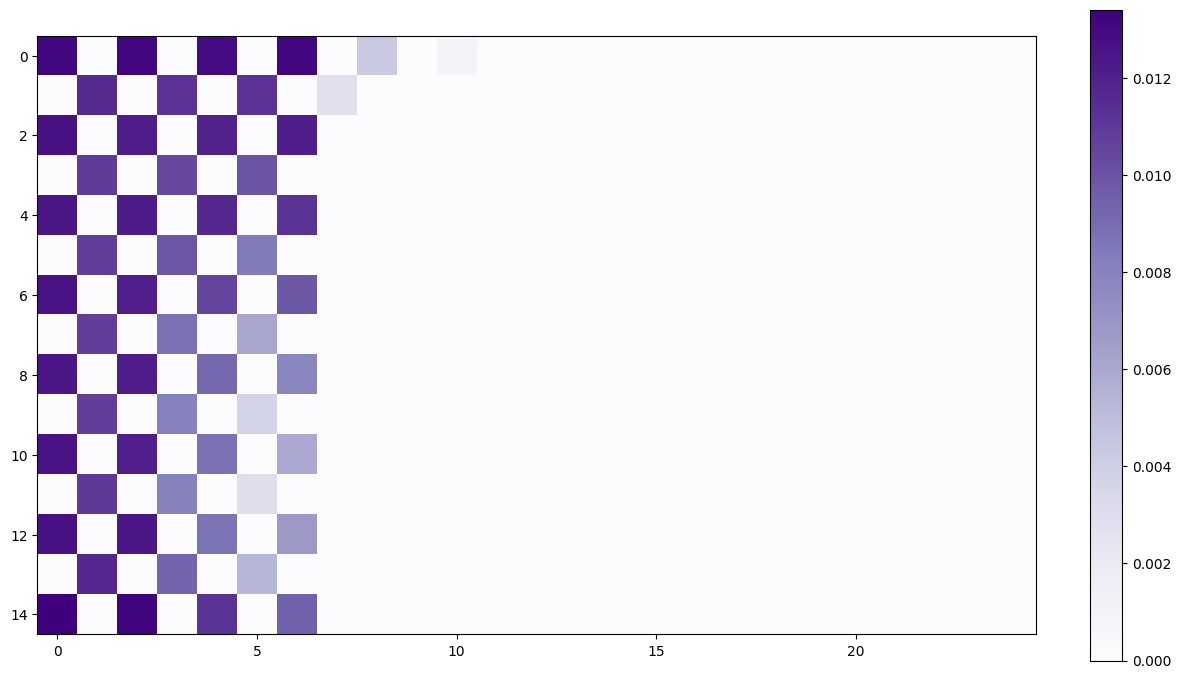

201.6602
201.61736


In [19]:
fig = plt.figure(figsize=(14, 18))
plot_data = plot_data.reshape(len(plot_data),1,15,25)
# plot_data = plot_data.reshape(len(plot_data),1,18,14)
# plot_data = plot_data.reshape(len(plot_data),1,8,13)

print(len(plot_data))
for j in range(len(plot_data[1])):
    plt.imshow(plot_data[4][j], cmap='Purples')
plt.colorbar(fraction=0.03, pad=0.05)
plt.show()

print(np.max(plot_data[0]))
print(np.sort(plot_data[0].reshape(1,-1))[0][-2])

# for k in range(len(plot_data)):
#     plt.imshow(plot_data[k][0], cmap='Purples')
#     if k == 0:
#         plt.colorbar(fraction=0.03, pad=0.05)
#     fig = plt.gcf()
#     plt.margins(0,0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/15x25d/EDCNN-estimate/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/8x13d/ANN-estimate/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/18x14d/ANN-estimate/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)

1


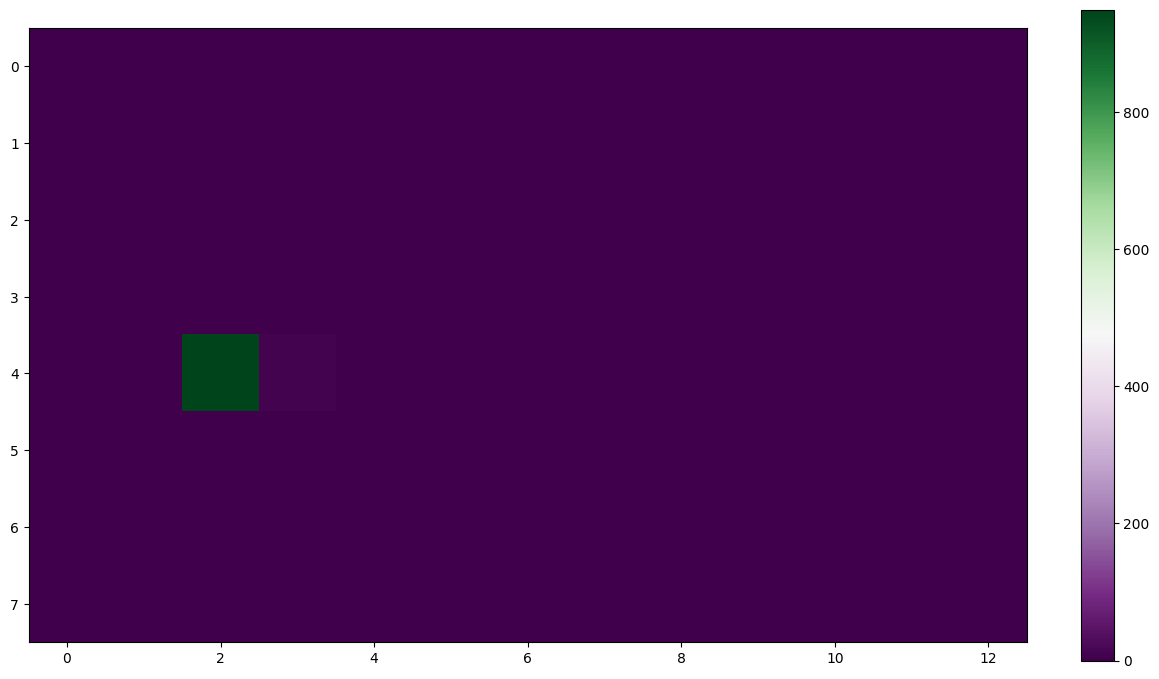

950.1021
544.1075


In [18]:
fig = plt.figure(figsize=(14, 18))
# plot_data1 = plot_data1.reshape(len(plot_data),1,15,25)
# plot_data1 = plot_data1.reshape(len(plot_data),1,18,14)
plot_data1 = plot_data1.reshape(len(plot_data1),1,8,13)
print(len(plot_data1[1]))
for j in range(len(plot_data1[1])):
#     plt.imshow(plot_data1[0][j], cmap='Purples')
    plt.imshow(plot_data1[-1][j], cmap='PRGn')

plt.colorbar(fraction=0.03, pad=0.05)
plt.show()

print(np.max(plot_data1[0]))
print(np.sort(plot_data1[0].reshape(1,-1))[0][-2])

# for k in range(len(plot_data1)):
#     plt.imshow(plot_data1[k][0], cmap='Purples')
#     if k == 0:
#         plt.colorbar(fraction=0.03, pad=0.05)
#     fig = plt.gcf()
#     plt.margins(0,0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/15x25d/EDCNN-true/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/8x13d/ANN-true/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/18x14d/ANN-true/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)

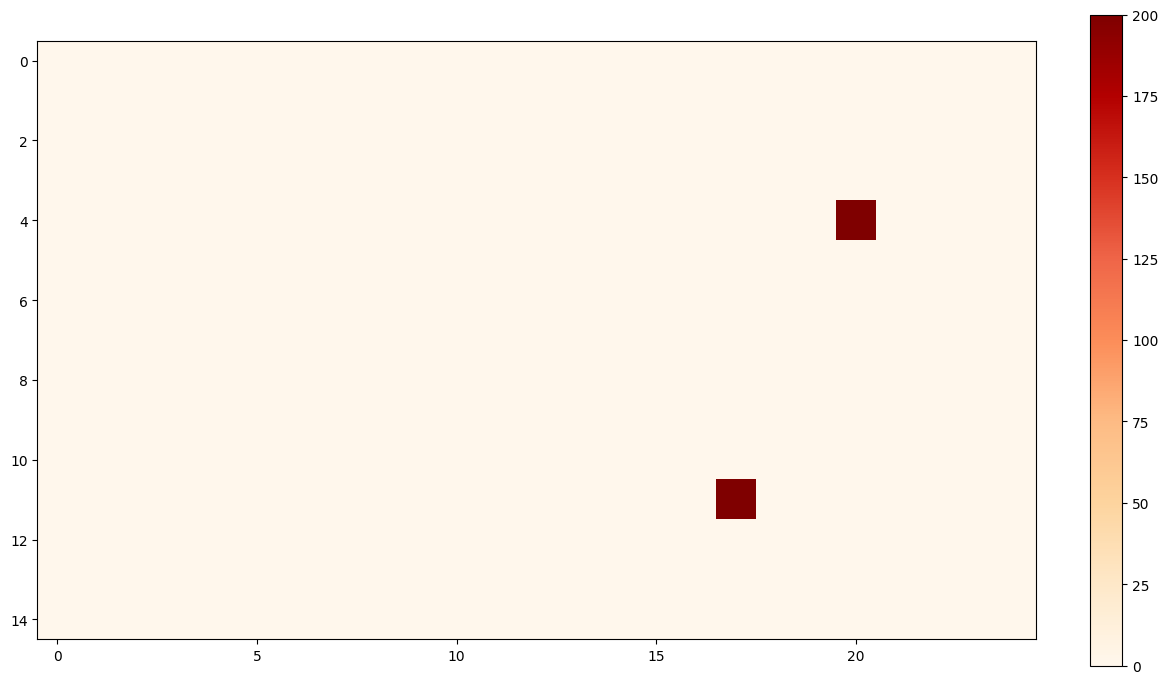

203.94121


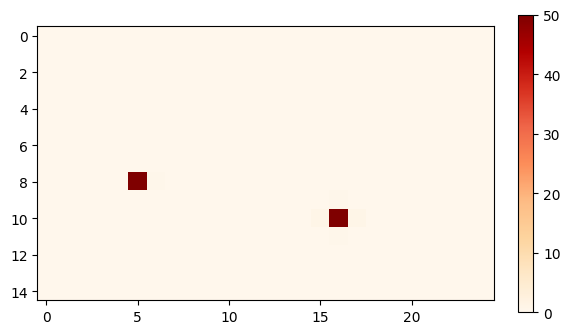

In [17]:
fig = plt.figure(figsize=(14, 18))

c = c.reshape(len(plot_data),1,15,25)
# c = c.reshape(len(plot_data),1,18,14)
# c = c.reshape(len(plot_data),1,8,13)

for j in range(len(c[0])):
    plt.imshow(c[4][j], cmap='OrRd', vmin = 0, vmax = 200)
plt.colorbar(fraction=0.03, pad=0.05)
plt.show()

print(np.max(c[-1]))

for k in range(len(c)):
    plt.imshow(c[k][0], cmap='OrRd', vmin = 0, vmax = 50)
    if k == 0:
        plt.colorbar(fraction=0.03, pad=0.05)
    fig = plt.gcf()
    plt.margins(0,0)
#     fig.savefig('reponse_map.png', dpi=500, bbox_inches='tight')  # dpi越高越清晰
#     plt.show()
#     plt.savefig("E:/study/FloPy/code/exam/pic/15x25d/EDCNN-error/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/8x13d/ANN-error/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)
#     plt.savefig("E:/study/FloPy/code/exam/pic/18x14d/ANN-error/{}.png".format(k), bbox_inches='tight', pad_inches=0.0)

##### 